# Module 3: Non-Bonded Interactions and Long-Range Electrostatics

## Introduction

Welcome to Module 3! In molecular dynamics (MD) simulations, **non-bonded interactions** are the forces between atoms that are not directly linked by chemical bonds (like covalent bonds). These interactions, primarily van der Waals forces and electrostatic forces, are the 'glue' that holds molecules together in condensed phases and dictates their structural and dynamic behavior. While often weaker on an individual basis than bonded interactions, their sheer number in a typical simulation makes their accurate and efficient calculation paramount.

This interactive notebook will guide you through:
1.  **The Lennard-Jones (LJ) Potential:** Understanding its mathematical form, physical meaning, and the practical necessity of using cutoffs.
2.  **The Coulomb Potential:** Recognizing the challenges posed by its long-range nature and why simple cutoffs, effective for LJ, are insufficient here.
3.  **The Ewald Summation Method:** Introducing a foundational technique to correctly handle long-range electrostatic interactions in periodic systems.
4.  **The Particle Mesh Ewald (PME) Method:** Discussing a highly efficient and widely used algorithm based on Ewald summation, enabling simulations of large biomolecular systems.
5.  **Visualizing Functional Forms:** Plotting key mathematical functions involved in these methods to build intuition.

Let's dive in!

## Lesson 3.1: Lennard-Jones (LJ) Potential and Cutoffs

The Lennard-Jones potential is a relatively simple yet powerful model used to describe the non-bonded interaction between two neutral atoms or non-polar molecules. It elegantly captures two fundamental forces:

* **Short-range repulsion:** Arising from Pauli exclusion principle when electron clouds overlap.
* **Long-range attraction:** Arising from induced dipole-induced dipole interactions (London dispersion forces).

The mathematical form of the LJ potential $V_{LJ}(r)$ between two particles separated by a distance $r$ is:

$$V_{LJ}(r) = 4\epsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^{6} \right]$$

Where:
-   $\epsilon$ (epsilon): The depth of the potential well. This parameter represents the strength of the attraction. A larger $\epsilon$ means a stronger attraction.
-   $\sigma$ (sigma): The finite distance at which the inter-particle potential $V_{LJ}(r)$ is zero. It is often considered the effective 'size' or diameter of the particle.
-   $r$: The distance between the centers of the two interacting particles.

The $(1/r)^{12}$ term models the repulsion, and the $-(1/r)^6$ term models the attraction. The high power of 12 for repulsion makes it a very steep potential at short distances, effectively preventing atoms from overlapping too much.

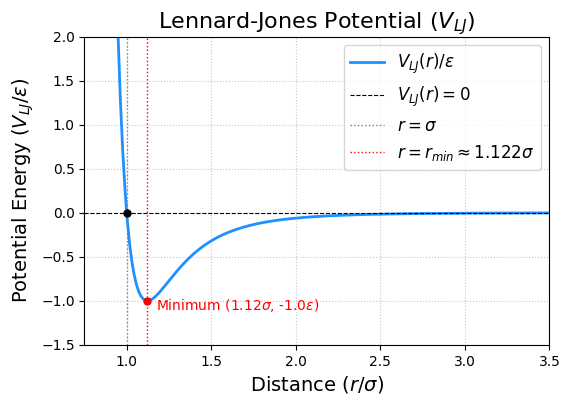

The potential is zero at r = 1.0 sigma.
The potential minimum occurs at r_min = 1.122 sigma, where V_LJ = -1.0 epsilon.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the Lennard-Jones potential function
def lj_potential(r, epsilon, sigma):
    """Calculates the Lennard-Jones potential."""
    # Ensure r is not zero or too small to avoid division by zero/overflow
    # For r values very close to 0, the potential should be very large (repulsive)
    # We'll handle this by clipping r or returning a large value for r < some_threshold * sigma
    # For plotting, it's often fine to start r from a small positive value.
    # For actual simulation, very small r would lead to huge forces.

    # Create a safe version of r to avoid division by zero or very small numbers
    # For r values smaller than a fraction of sigma (e.g., 0.5*sigma), the potential is extremely repulsive.
    # We can cap the potential or filter r for plotting.
    r_safe = np.maximum(r, 0.001) # Prevent r=0, use a small floor

    term12 = (sigma / r_safe)**12
    term6 = (sigma / r_safe)**6
    potential = 4 * epsilon * (term12 - term6)
    return potential

# Parameters for the LJ potential (using generic epsilon=1, sigma=1 for easy interpretation)
epsilon_lj = 1.0  # Arbitrary energy unit
sigma_lj = 1.0    # Arbitrary length unit

# Generate a range of distances for plotting
# Start r slightly above 0 to avoid extreme repulsive values at r=0 if not handled by lj_potential
r_values = np.linspace(0.8 * sigma_lj, 3.5 * sigma_lj, 200)

# Calculate the LJ potential
potential_lj_values = lj_potential(r_values, epsilon_lj, sigma_lj)

# Find the minimum of the potential
r_min = sigma_lj * (2**(1/6))  # Distance at which V_LJ is minimum
V_min = lj_potential(r_min, epsilon_lj, sigma_lj) # Should be -epsilon_lj

# Plotting the LJ potential
plt.figure(figsize=(6,4))
plt.plot(r_values / sigma_lj, potential_lj_values / epsilon_lj, label=r'$V_{LJ}(r) / \epsilon$', color='dodgerblue', linewidth=2)

# Add a horizontal line at V=0
plt.axhline(0, color='black', linestyle='--', linewidth=0.8, label=r'$V_{LJ}(r) = 0$')

# Mark sigma on the x-axis (where V_LJ = 0)
plt.axvline(1.0, color='grey', linestyle=':', linewidth=1, label=r'$r = \sigma$')
plt.plot(1.0, 0, 'ko', markersize=5) # Mark the point (sigma, 0)

# Mark the minimum of the potential well
plt.axvline(r_min / sigma_lj, color='red', linestyle=':', linewidth=1, label=r'$r = r_{min} \approx 1.122\sigma$')
plt.plot(r_min / sigma_lj, V_min / epsilon_lj, 'ro', markersize=5) # Mark the minimum point
plt.text(r_min / sigma_lj + 0.05, V_min / epsilon_lj -0.1, f'Minimum ({r_min/sigma_lj:.2f}$\sigma$, {-epsilon_lj:.1f}$\epsilon$)', color='red')

plt.title('Lennard-Jones Potential ($V_{LJ}$)', fontsize=16)
plt.xlabel(r'Distance ($r / \sigma$)', fontsize=14)
plt.ylabel(r'Potential Energy ($V_{LJ} / \epsilon$)', fontsize=14)
plt.ylim(-1.5, 2.0) # Adjust y-limits for better visualization of the well
plt.xlim(0.75, 3.5) # Adjust x-limits to focus on the relevant part
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

print(f"The potential is zero at r = {sigma_lj:.1f} sigma.")
print(f"The potential minimum occurs at r_min = {r_min/sigma_lj:.3f} sigma, where V_LJ = {V_min/epsilon_lj:.1f} epsilon.")

### The Need for Cutoffs in LJ Interactions

In a simulation with $N$ particles, calculating all pairwise interactions involves $N(N-1)/2$ pairs, which scales as $O(N^2)$. For large $N$ (e.g., thousands to millions of atoms), this becomes computationally prohibitive.

Fortunately, the attractive part of the LJ potential decays as $r^{-6}$. This is relatively fast, meaning that beyond a certain distance, the interaction energy and force become negligible. We can exploit this by introducing a **cutoff radius ($r_c$)**.

If the distance $r$ between two particles is greater than $r_c$, their LJ interaction is assumed to be zero:

$$ V_{LJ,cutoff}(r) = \begin{cases} V_{LJ}(r) & \text{if } r \le r_c \\ 0 & \text{if } r > r_c \end{cases} $$

A common choice for $r_c$ is around $2.5\sigma$ to $3.5\sigma$. At $r = 2.5\sigma$, $V_{LJ}(r) \approx -0.016\epsilon$, which is only about 1.6% of the well depth.

**Issues with Simple Truncation:**
Simply setting the potential to zero beyond $r_c$ (a "truncated potential") creates a discontinuity in the potential energy if $V_{LJ}(r_c) \neq 0$. This, in turn, leads to an infinite force ($F = -dV/dr$) at $r_c$, which is unphysical and can cause problems in simulations, such as poor energy conservation.

**Correction: Shifted Potential**
To address the discontinuity in energy, the potential can be shifted so that it becomes zero at the cutoff:

$$V_{LJ,shifted}(r) = \begin{cases} V_{LJ}(r) - V_{LJ}(r_c) & \text{if } r \le r_c \\ 0 & \text{if } r > r_c \end{cases}$$

This ensures $V_{LJ,shifted}(r_c) = 0$, making the potential energy continuous. However, the *force* (the derivative of the potential) might still be discontinuous at $r_c$ unless $dV_{LJ}/dr|_{r=r_c} = 0$, which is generally not true. More sophisticated switching functions can make both the potential and force go smoothly to zero, but a shifted potential is a common and simpler improvement over simple truncation.

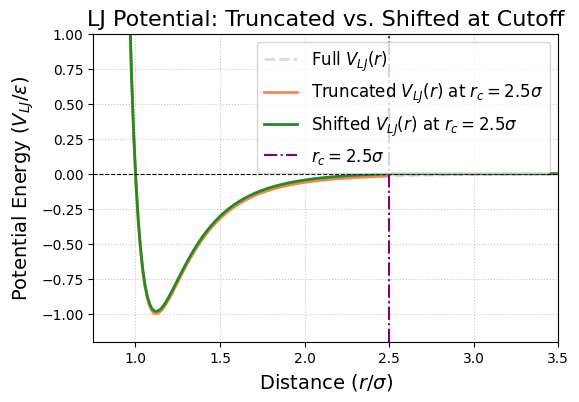

Value of original LJ potential at cutoff r_c=2.5 sigma: V_LJ(r_c) = -0.0163 epsilon
Value of shifted LJ potential at cutoff r_c=2.5 sigma: V_LJ_shifted(r_c) = 0.0 epsilon


In [ ]:
# Define a cutoff radius
rc_lj = 2.5 * sigma_lj  # A common cutoff value

# Calculate potential at the cutoff for shifting
V_at_rc = lj_potential(rc_lj, epsilon_lj, sigma_lj)

# Calculate LJ potential with simple truncation and with shifting
potential_truncated_values = np.array([lj_potential(r, epsilon_lj, sigma_lj) if r <= rc_lj else 0 for r in r_values])
potential_shifted_values = np.array([(lj_potential(r, epsilon_lj, sigma_lj) - V_at_rc) if r <= rc_lj else 0 for r in r_values])

# Plotting to compare
plt.figure(figsize=(6,4))
plt.plot(r_values / sigma_lj, potential_lj_values / epsilon_lj, label=r'Full $V_{LJ}(r)$', color='lightgrey', linestyle='--', linewidth=2, alpha=0.8)
plt.plot(r_values / sigma_lj, potential_truncated_values / epsilon_lj, label=r'Truncated $V_{LJ}(r)$ at $r_c=2.5\sigma$', color='coral', linestyle='-', linewidth=2)
plt.plot(r_values / sigma_lj, potential_shifted_values / epsilon_lj, label=r'Shifted $V_{LJ}(r)$ at $r_c=2.5\sigma$', color='forestgreen', linestyle='-', linewidth=2)

# Add a horizontal line at V=0
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

# Mark the cutoff radius on the x-axis
plt.axvline(rc_lj / sigma_lj, color='purple', linestyle='-.', linewidth=1.5, label=f'$r_c = {rc_lj/sigma_lj:.1f}\sigma$')

plt.title('LJ Potential: Truncated vs. Shifted at Cutoff', fontsize=16)
plt.xlabel(r'Distance ($r / \sigma$)', fontsize=14)
plt.ylabel(r'Potential Energy ($V_{LJ} / \epsilon$)', fontsize=14)
plt.ylim(-1.2 * epsilon_lj, 1.0 * epsilon_lj) # Adjusted ylim
plt.xlim(0.75, 3.5) # Adjusted xlim
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

print(f"Value of original LJ potential at cutoff r_c={rc_lj/sigma_lj:.1f} sigma: V_LJ(r_c) = {V_at_rc/epsilon_lj:.4f} epsilon")
print(f"Value of shifted LJ potential at cutoff r_c={rc_lj/sigma_lj:.1f} sigma: V_LJ_shifted(r_c) = {(V_at_rc - V_at_rc)/epsilon_lj:.1f} epsilon")

## Lesson 3.2: Coulomb Interactions and the Challenge of Long-Range Forces

Electrostatic interactions are fundamental in many, if not most, molecular systems, especially those involving ions, polar molecules (like water), or biomolecules (proteins, DNA have many charged groups).

The Coulomb potential $V_C(r)$ between two point charges $q_i$ and $q_j$ separated by a distance $r_{ij}$ in a vacuum is given by:

$$V_C(r_{ij}) = \frac{1}{4\pi\epsilon_0} \frac{q_i q_j}{r_{ij}}$$

Where:
-   $q_i, q_j$ are the magnitudes of the charges.
-   $\epsilon_0$ is the permittivity of free space (a fundamental physical constant).
-   $r_{ij}$ is the distance between the charges.

In simulation units, the constant term $1/(4\pi\epsilon_0)$ is often absorbed into a single constant, let's call it $k_e$ (Coulomb's constant), or units are chosen such that it's 1.

$$V_C(r_{ij}) = k_e \frac{q_i q_j}{r_{ij}}$$

The most critical characteristic of the Coulomb potential is its **long-range nature**: it decays as $1/r$. This decay is much, much slower than the $1/r^6$ decay of the attractive part of the LJ potential.

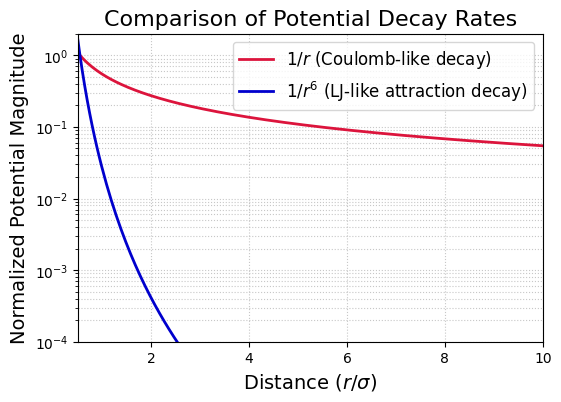

Note how much slower the 1/r decay is compared to 1/r^6, especially at larger distances.


In [ ]:
# Define the Coulomb potential function (simplified k_e*q_i*q_j = 1 for plotting shape)
def coulomb_potential(r, strength=1.0):
    """Calculates a simplified Coulomb-like potential (1/r)."""
    # Avoid division by zero for r=0
    r_safe = np.maximum(r, 0.001)
    return strength / r_safe

# Generate distances for plotting
r_coul_values = np.linspace(0.2, 10.0, 200) # Start further from 0 for 1/r

# Calculate potentials for comparison
potential_coulomb = coulomb_potential(r_coul_values)
potential_lj_attraction_part = -lj_potential(r_coul_values, epsilon_lj, sigma_lj) # Focus on attractive part of LJ for decay comparison
# Or more simply, just plot 1/r^6 vs 1/r
lj_decay_comparison = (sigma_lj / r_coul_values)**6

plt.figure(figsize=(6,4))
plt.plot(r_coul_values / sigma_lj, potential_coulomb / np.max(potential_coulomb[r_coul_values/sigma_lj > 0.5]), label=r'$1/r$ (Coulomb-like decay)', color='crimson', linewidth=2)
plt.plot(r_coul_values / sigma_lj, lj_decay_comparison / np.max(lj_decay_comparison[r_coul_values/sigma_lj > 0.5]), label=r'$1/r^6$ (LJ-like attraction decay)', color='mediumblue', linewidth=2)

plt.title('Comparison of Potential Decay Rates', fontsize=16)
plt.xlabel(r'Distance ($r / \sigma$)', fontsize=14)
plt.ylabel('Normalized Potential Magnitude', fontsize=14)
plt.yscale('log') # Log scale is essential to see the difference at larger r
plt.ylim(1e-4, 2) # Adjust y limits for log scale
plt.xlim(0.5, 10) # Show a wider range for decay
plt.legend(fontsize=12)
plt.grid(True, which="both", linestyle=':', alpha=0.7) # Grid for both major and minor ticks on log scale
plt.show()

print("Note how much slower the 1/r decay is compared to 1/r^6, especially at larger distances.")

### Why Simple Cutoffs Fail Miserably for Coulomb Interactions

The slow $1/r$ decay of the Coulomb potential means that interactions from distant charges can still be significant. Applying a simple spherical cutoff (like we did for LJ interactions) to Coulomb interactions in a periodic system leads to severe problems:

1.  **Significant Neglected Interactions:** The sum of $q_i q_j / r_{ij}$ over all pairs in a truly infinite system (or one with periodic boundary conditions, PBC) converges very slowly, and its value is *conditionally convergent*. This means the sum depends on the order of summation or, equivalently, the shape of the boundary assumed for the summation. Truncating it at a typical molecular cutoff (e.g., 10-15 Å) means you are ignoring a substantial, non-negligible portion of the total electrostatic energy and forces. This isn't just a small error; it can fundamentally change the physics.

2.  **Artificial Structuring and Anisotropy:** In a system with PBC, if you use a spherical cutoff for Coulomb forces, a charge $q_i$ interacts with charges $q_j$ within its cutoff sphere. However, it does *not* see the periodic images of $q_j$ that lie outside this sphere, nor does it see charges beyond the sphere that are part of the bulk periodic system. This creates an artificial boundary and can lead to:
    * **Distortion of solvent structure:** Polar molecules like water might artificially orient themselves with respect to the cutoff sphere rather than the true long-range field of the system.
    * **Incorrect dielectric properties:** The system's response to electric fields will be wrong.
    * **Spurious effects on charged species:** Ions might experience artificial forces or accumulate near these imaginary boundaries.
    * **System-size dependent artifacts:** Properties can change unphysically if you change the box size but keep the cutoff the same.

3.  **No Net Charge Neutrality within the Cutoff Sphere:** Even if the overall simulation box is charge neutral, the region within an arbitrary cutoff sphere around a given particle is generally *not* charge neutral. This means each particle effectively sees a net charged environment if only interactions within the cutoff are considered, which is unphysical for a bulk, neutral system.

4.  **Severe Energy Drift:** A sharp cutoff in the Coulomb potential creates very large discontinuities in the forces at $r_c$. This leads to extremely poor energy conservation in MD simulations, making the simulation unreliable.

**Consider this:** The number of particles in a shell of thickness $dr$ at distance $r$ grows as $4\pi r^2 dr$. The interaction energy with these particles would be proportional to $(r^2 dr) \times (1/r) = r dr$. Integrating this, $\int r dr = r^2/2$, suggests that distant shells contribute *more* to the potential, not less! This simple argument is for a uniform distribution and needs refinement for specific lattices, but it highlights the danger of truncation.

**Conclusion for Coulomb:** Using a simple spherical cutoff (even with shifting) for Coulomb interactions is **fundamentally flawed** for most simulations, especially those involving charged or polar species in periodic boundary conditions. It can lead to qualitatively incorrect results. Specialized methods are absolutely essential.


## Lesson 3.3: The Ewald Summation Method

The Ewald summation method, developed by Paul Peter Ewald in the early 20th century (initially for calculating electrostatic energies of ionic crystals), provides a mathematically sound way to calculate the electrostatic energy (and forces) of an infinite, periodic system of charges. It elegantly sidesteps the conditional convergence problem of the direct $1/r$ sum.

**The Core Idea: Splitting the Sum**

The Ewald method cleverly splits the problematic $1/r_{ij}$ sum into two parts, each of which converges much more rapidly:
1.  A **short-ranged real-space sum**.
2.  A **smooth, long-ranged reciprocal-space (Fourier space) sum**.

This is achieved by a mathematical trick: imagine each point charge $q_j$ is surrounded by a diffuse Gaussian charge distribution of the *opposite* sign ($-q_j$). This Gaussian cloud effectively screens the point charge, making its interaction with other charges decay much faster. The interaction between these screened charges and the original point charges is calculated directly in real space (this is the real-space sum) and can now be truncated with a cutoff.

However, we've artificially added these screening Gaussians. To compensate, we must subtract their effect. This is done by adding a *second* set of Gaussian charge distributions, this time with the *same* sign ($+q_j$) as the original charges. This sum of diffuse, identical Gaussians creates a smooth, periodic potential throughout the simulation cell. Because this potential is smooth and periodic, it can be efficiently represented by a rapidly converging Fourier series, which is calculated in reciprocal space (this is the reciprocal-space sum).

**The Ewald Sum Components:**
The total electrostatic energy $U_{total}$ in an Ewald summation is typically expressed as the sum of several terms:

$$ U_{total} = U_{real} + U_{reciprocal} + U_{self} + U_{dipole} \text{ (if applicable)} $$

-   **$U_{real}$ (Real-space term):** This is the sum of interactions between charges, where each charge is screened by its neutralizing Gaussian. The interaction potential takes the form $q_i q_j \frac{\text{erfc}(\alpha r_{ij})}{r_{ij}}$, where $\text{erfc}$ is the complementary error function and $\alpha$ is the Ewald splitting parameter. This sum is short-ranged and can be truncated at a cutoff $r_c$.

$$V_{real}(r_{ij}) = k_e \frac{q_i q_j}{r_{ij}} \text{erfc}(\alpha r_{ij})$$

-   **$U_{reciprocal}$ (Reciprocal-space term):** This term accounts for the interaction of the smooth, compensating Gaussian charge distributions. It's calculated as a sum over reciprocal lattice vectors $\mathbf{k}$.

$$ U_{recip} = \frac{k_e}{2V} \sum_{ \mathbf{k} \neq 0} \frac{4\pi}{k^2} |S(\mathbf{k})|^2 \exp(-k^2 / 4\alpha^2) $$
    
where $V$ is the cell volume, $S(\mathbf{k}) = \sum_j q_j \exp(i \mathbf{k} \cdot \mathbf{r}_j)$ is the structure factor, and $k = |\mathbf{k}|$. This sum converges quickly if $\alpha$ is chosen appropriately.

-   **$U_{self}$ (Self-interaction correction):** An artifact of the method is that each charge interacts with its own screening Gaussian. This unphysical self-interaction must be subtracted.
    $$ U_{self} = -k_e \frac{\alpha}{\sqrt{\pi}} \sum_j q_j^2 $$

-   **$U_{dipole}$ (Surface/Dipole term - optional):** If the simulation cell has a net dipole moment, an additional term might be needed depending on the assumed boundary conditions at infinity (e.g., vacuum, or surrounded by a perfect conductor). For systems with no net dipole, or when using "tin-foil" (conducting) boundary conditions, this term is often zero or handled implicitly.

**The Ewald Splitting Parameter ($\alpha$ or $\kappa$):**
This crucial parameter (often denoted $\alpha$, sometimes $\kappa$ or $\beta$) controls the width of the Gaussian charge distributions. It dictates the balance of computational effort between the real-space and reciprocal-space sums:
-   **Large $\alpha$:** Narrow Gaussians, meaning the real-space interaction $q_i q_j \text{erfc}(\alpha r_{ij})/r_{ij}$ decays very quickly (fewer terms needed in the real-space sum, smaller $r_c$). However, the compensating charge distribution in reciprocal space becomes broader, so the reciprocal sum converges more slowly (more $\mathbf{k}$-vectors needed).
-   **Small $\alpha$:** Wide Gaussians. The real-space sum converges slowly (larger $r_c$ needed). The reciprocal-space sum converges quickly (fewer $\mathbf{k}$-vectors needed).
The optimal choice of $\alpha$ (along with $r_c$ and the $k$-space cutoff $k_{max}$) is one that minimizes the total computational cost for a desired accuracy.

**Advantages of Ewald Summation:**
-   Provides a mathematically rigorous and accurate way to calculate long-range electrostatic interactions in periodic systems.
-   Converges much faster than attempting a direct, brute-force summation.

**Disadvantages:**
-   Significantly more complex to understand and implement than simple cutoffs.
-   The computational cost of traditional Ewald scales roughly as $O(N^{3/2})$ or $O(N^2)$ depending on implementation choices (where $N$ is the number of particles), which can still be a bottleneck for very large systems.

### Reciprocal Space Term in Ewald Summation

The reciprocal-space term involves a sum over reciprocal lattice vectors $\mathbf{k}$. The key component related to damping in k-space (Fourier space) is $\exp(-k^2 / 4\alpha^2)/k^2$.

- If $\alpha$ is **large** (fast real-space decay), then $1/(4\alpha^2)$ is small. This means $\exp(-k^2 / 4\alpha^2)$ decays slowly with $k$, so more $\mathbf{k}$-vectors are needed in the reciprocal sum.
- If $\alpha$ is **small** (slow real-space decay), then $1/(4\alpha^2)$ is large. This means $\exp(-k^2 / 4\alpha^2)$ decays quickly with $k$, so fewer $\mathbf{k}$-vectors are needed.

This illustrates the trade-off controlled by $\alpha$.

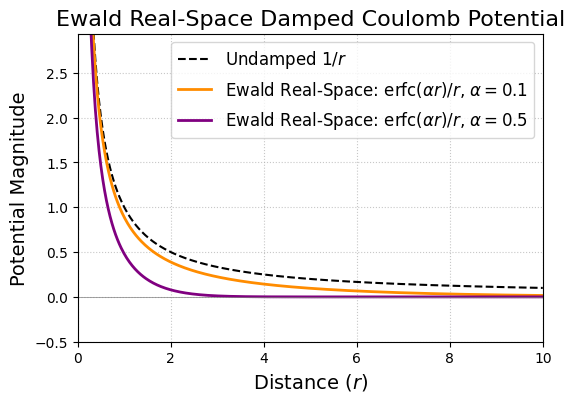

With larger alpha (0.5), the real-space potential decays much faster.
With smaller alpha (0.1), the real-space potential decays slower, resembling 1/r more closely at short distances but still eventually decaying faster.


In [ ]:
from scipy.special import erfc # Complementary error function

# Define the Ewald real-space damped Coulomb potential part
def ewald_real_space_term(r, alpha, strength=1.0):
    """Calculates the erfc(alpha*r)/r part of Ewald real-space sum."""
    r_safe = np.maximum(r, 0.0001) # Avoid r=0
    return strength * erfc(alpha * r_safe) / r_safe

# Parameters for plotting
r_ewald = np.linspace(0.1, 10.0, 500) # Distances
alpha_small = 0.1  # Smaller alpha: wider screening Gaussian, slower real-space decay
alpha_large = 0.5  # Larger alpha: narrower screening Gaussian, faster real-space decay

# Calculate potentials
potential_coulomb_ref = coulomb_potential(r_ewald) # Undamped 1/r for reference
damped_potential_small_alpha = ewald_real_space_term(r_ewald, alpha_small)
damped_potential_large_alpha = ewald_real_space_term(r_ewald, alpha_large)

plt.figure(figsize=(6,4))
plt.plot(r_ewald, potential_coulomb_ref, label=r'Undamped $1/r$', color='black', linestyle='--', linewidth=1.5) # Fixed: Added closing $ to the label
plt.plot(r_ewald, damped_potential_small_alpha, label=r'Ewald Real-Space: $\operatorname{{erfc}}(\alpha r)/r$, $\alpha={}$'.format(alpha_small), color='darkorange', linewidth=2)
plt.plot(r_ewald, damped_potential_large_alpha, label=r'Ewald Real-Space: $\operatorname{{erfc}}(\alpha r)/r$, $\alpha={}$'.format(alpha_large), color='purple', linewidth=2)

plt.title('Ewald Real-Space Damped Coulomb Potential', fontsize=16)
plt.xlabel(r'Distance ($r$)', fontsize=14)
plt.ylabel('Potential Magnitude', fontsize=14)
plt.ylim(-0.5, np.max(potential_coulomb_ref[r_ewald > 0.5])+1) # Adjust y-limit based on 1/r values
plt.xlim(0, 10)
plt.axhline(0, color='grey', linestyle='-', linewidth=0.5)
plt.legend(fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

print(f"With larger alpha ({alpha_large}), the real-space potential decays much faster.")
print(f"With smaller alpha ({alpha_small}), the real-space potential decays slower, resembling 1/r more closely at short distances but still eventually decaying faster.")

## Lesson 3.4: Particle Mesh Ewald (PME) Method

While traditional Ewald summation is accurate, its $O(N^{3/2})$ to $O(N^2)$ scaling makes it computationally intensive for systems with many thousands of atoms. The **Particle Mesh Ewald (PME)** method, developed by Darden, York, and Pedersen, and similar Particle-Particle Particle-Mesh (PPPM) methods, offer a more efficient way to calculate the reciprocal-space part of the Ewald sum. PME has become the de facto standard for treating long-range electrostatics in large-scale biomolecular simulations, reducing the scaling to approximately $O(N \log N)$.

**The Core Idea of PME: Using FFTs for Reciprocal Sum**

PME retains the real-space sum and self-interaction correction from the standard Ewald method. The innovation lies in how it computes the reciprocal-space sum. Instead of a direct summation over $\mathbf{k}$-vectors, PME uses a grid and Fast Fourier Transforms (FFTs):

1.  **Charge Assignment (Gridding):**
    * A regular 3D grid (mesh) is superimposed on the simulation box.
    * The point charges of the particles are assigned (interpolated) onto the nearby grid points. This is not a simple nearest-grid-point assignment; instead, smooth interpolation functions (e.g., B-splines of various orders) are used to distribute each charge onto a small stencil of surrounding grid points. This process creates a gridded charge density, $\rho(\mathbf{r}_{grid})$. The smoothness of the interpolation is crucial for accuracy.

2.  **Reciprocal Sum Calculation (via FFTs):**
    * The electrostatic potential on the grid, $\Phi(\mathbf{r}_{grid})$, due to the gridded charge density $\rho(\mathbf{r}_{grid})$ is calculated by solving Poisson's equation in Fourier space. This involves several steps:
        a.  **FFT of Charge Density:** Compute the Fourier transform of the gridded charge density: $\hat{\rho}(\mathbf{k}) = \text{FFT}(\rho(\mathbf{r}_{grid}))$.
        b.  **Multiplication by Influence Function:** Multiply $\hat{\rho}(\mathbf{k})$ by the (discretized) Ewald Green's function or influence function in Fourier space, $\hat{G}(\mathbf{k})$. This $\hat{G}(\mathbf{k})$ is essentially the $\exp(-k^2 / 4\alpha^2)/k^2$ term from the Ewald reciprocal sum, adapted for the grid and the interpolation scheme.
        c.  **Inverse FFT for Potential:** Compute the inverse FFT of the product to get the electrostatic potential on the grid: $\Phi(\mathbf{r}_{grid}) = \text{IFFT}(\hat{G}(\mathbf{k}) \hat{\rho}(\mathbf{k}))$.
    * The reciprocal space energy can then be calculated from the gridded charge density and potential.

3.  **Force/Potential Interpolation:**
    * The electrostatic potential (and its derivatives, which give the forces) are interpolated from the grid points *back* to the actual particle positions. The same (or a related) interpolation scheme used in the charge assignment step is typically employed here to maintain consistency and accuracy (e.g., using the derivatives of the B-spline functions).

4.  **Real-Space and Self-Interaction Terms:**
    * The direct, short-range part of the Ewald sum (screened Coulomb interactions $q_i q_j \text{erfc}(\alpha r_{ij})/r_{ij}$) is calculated exactly as in the standard Ewald method, typically within a cutoff radius $r_c$. This corrects for the approximations made by the grid-based calculation at short distances where the grid might be too coarse to represent interactions accurately.
    * The self-interaction correction is also applied as in standard Ewald.

**Advantages of PME:**
-   **Outstanding Efficiency:** The use of FFTs for the reciprocal sum is the key. FFTs scale as $O(M \log M)$, where $M$ is the number of grid points. If $M$ is chosen to be proportional to $N$ (the number of particles), the overall scaling of PME becomes approximately $O(N \log N)$. This is a dramatic improvement over $O(N^{3/2})$ or $O(N^2)$ and makes simulations of systems with hundreds of thousands or even millions of atoms feasible.
-   **High Accuracy:** PME can achieve high accuracy, comparable to standard Ewald, by appropriately choosing the Ewald splitting parameter $\alpha$, the real-space cutoff $r_c$, the grid spacing (number of FFT grid points), and the order of the interpolation scheme (e.g., cubic or quartic B-splines are common).

**Implementation Complexity and Usage:**
PME is algorithmically sophisticated. Its robust and efficient implementation involves careful handling of FFTs, spline interpolation, differentiation of splines for forces, and managing communication in parallel environments. Fortunately, users of modern MD simulation packages (like GROMACS, AMBER, NAMD, CHARMM, LAMMPS, OpenMM) do not need to implement PME themselves. It is a standard, highly optimized feature. However, users *do* need to understand the key parameters that control its accuracy and performance to make sensible choices for their simulations:
-   `ewald_rtol` (or similar): Desired relative accuracy for Ewald, which helps determine $\alpha$, $r_c$, and $k_{max}$ (or FFT grid density).
-   `fourierspacing` (or `fft_spacing`): The approximate spacing between FFT grid points. Finer grids give more accuracy but cost more.
-   `pme_order` (or `interpolation_order`): The order of the B-spline interpolation (e.g., 4 for cubic, 6 for quintic). Higher orders are more accurate but computationally more intensive.

**In essence, PME revolutionized the simulation of large biomolecular systems by providing an accurate and computationally tractable method for handling the all-important long-range electrostatic interactions.**

## Lesson 3.5: Summary & Key Takeaways for Module 3

This module has explored the critical aspects of handling non-bonded interactions in molecular dynamics simulations.

1.  **Lennard-Jones (LJ) Potential:** Models van der Waals forces (short-range repulsion, longer-range attraction). Its relatively fast $r^{-6}$ attractive decay allows for the use of a **cutoff radius ($r_c$)** to improve computational efficiency. Simple truncation can cause energy discontinuities; **shifted potentials** (or more advanced switching functions) are preferred to ensure $V(r_c)=0$.

2.  **Coulomb Potential:** Describes electrostatic interactions between charged particles. Its very slow $1/r$ decay makes **simple truncation schemes fundamentally unsuitable** for periodic systems. Doing so leads to significant inaccuracies, artificial structuring, and poor energy conservation, rendering simulation results unreliable for most systems where electrostatics are important.

3.  **Ewald Summation:** A rigorous mathematical technique to accurately calculate electrostatic interactions in periodic systems. It cleverly splits the slowly converging $1/r$ sum into a **short-range real-space sum** (using a damped Coulomb interaction, $\text{erfc}(\alpha r)/r$) and a **rapidly converging reciprocal-space (Fourier) sum**. An Ewald splitting parameter, $\alpha$, balances the computational load between these two sums. While accurate, traditional Ewald typically scales as $O(N^{3/2})$ to $O(N^2)$.

4.  **Particle Mesh Ewald (PME):** An highly efficient algorithm for computing the Ewald sum, particularly its reciprocal-space component. PME uses a **grid (mesh)** to assign charges, then employs **Fast Fourier Transforms (FFTs)** to solve for the electrostatic potential on the grid. Forces are then interpolated back to the particles. This reduces the computational scaling for long-range electrostatics to approximately $O(N \log N)$, making it the method of choice for large-scale simulations.

**Overall Importance:**
Understanding how non-bonded interactions are defined and calculated is crucial for any MD practitioner. The choice of how to treat long-range forces, in particular, can dramatically impact the accuracy and validity of simulation results. While LJ cutoffs are standard, the necessity of methods like PME for electrostatics cannot be overstated for realistic simulations of biomolecules, ionic solutions, or any system where charges play a significant role.

### Conceptual Exercises & Further Thought

1.  **LJ Cutoff Artifacts:** In the plot showing "Truncated vs. Shifted" LJ potentials, imagine calculating the force ($F = -dV/dr$) at the cutoff $r_c$. Describe qualitatively what the force would look like for the truncated potential versus the shifted potential right at $r_c$. Why is a discontinuity in force problematic for MD simulations?
2.  **Ewald Parameter $\alpha$:** If you were forced to use a very small real-space cutoff $r_c$ for the Ewald sum (due to memory constraints, for example), would you prefer a larger or smaller value of $\alpha$? Explain your reasoning in terms of the convergence of the real and reciprocal sums.
3.  **PME Grid Spacing:** What do you think are the consequences of choosing a very coarse FFT grid (large `fourierspacing`) in a PME calculation? Conversely, what about a very fine grid (small `fourierspacing`)?
4.  **Why not Ewald for LJ?** The attractive part of the LJ potential is $-(1/r)^6$. Could one, in principle, develop an Ewald-like summation method for this $r^{-6}$ term if it were the dominant long-range interaction and simple cutoffs were insufficient (e.g., for extremely high accuracy studies)? What might be some practical reasons why this is generally not done for standard LJ interactions?
5.  **Real-world Impact:** Consider a simulation of DNA (highly charged) in a water solution with salt ions. Why would using a simple 1 nm cutoff for *all* non-bonded interactions (both LJ and Coulomb) likely lead to completely incorrect simulation results regarding DNA structure or ion binding?